# Step by step Optimization : understanding gradient based method

In [1]:
%matplotlib widget
#%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import ipywidgets as ipw
from matplotlib import cm
import ipywidgets as widgets

## Cost functions

###  Goldstein–Price function

In [2]:
def cost(p):
    global counterCostCall
    """
    Goldstein–Price.
    https://en.wikipedia.org/wiki/Test_functions_for_optimization    """

    x, y = p
    f = (
        1
        + (
            (x + y + 1) ** 2
            * (19 - 14 * x + 3 * x**2 - 14 * y + 6 * x * y + 3 * y**2)
        )
    ) * (
        30
        + (2 * x - 3 * y) ** 2
        * (18 - 32 * x + 12 * x**2 + 48 * y - 36 * x * y + 27 * y**2)
    )
    return f / 80000.0


counterCostCall = 0
Nx, Ny = 100, 100
x = np.linspace(-1.5, 1.5, Nx)
y = np.linspace(-1.5, 1.5, Ny)
X, Y = np.meshgrid(x, y)
zf = np.array([X.flatten(), Y.flatten()])
Z = cost(zf).reshape(Nx, Ny)
Z = np.where(Z > 0.3, np.nan, Z)
mask = np.ones_like(Z)

###  Himmelblau cost function

In [3]:
def cost(p):
    global counterCostCall
    """
    Himmelblau cost function.
    https://en.wikipedia.org/wiki/Himmelblau%27s_function
    """

    x, y = p
    return (x**2 + y - 11) ** 2 + (x + y**2 - 7) ** 2


counterCostCall = 0
Nx, Ny = 100, 100
x = np.linspace(-5.0, 5.0, Nx)
y = np.linspace(-5.0, 5.0, Ny)
X, Y = np.meshgrid(x, y)
zf = np.array([X.flatten(), Y.flatten()])
Z = cost(zf).reshape(Nx, Ny)
Z = np.where(Z > 200.0, np.nan, Z)

mask = np.ones_like(Z)

In [4]:
P = np.zeros((1000, 2)) * np.nan
V_down_hill_dir = np.zeros((1000, 2)) * np.nan


P[0] = 3.0, -0.0


def maj_mask_all(mask, Pis):
    for Pi in Pis:
        if ~np.isnan(Pi[0]):
            mask = maj_mask(mask, Pi)
    return mask


def maj_mask(mask, Pi):
    R = 0.5
    mask[np.sqrt((X - Pi[0]) ** 2 + (Y - Pi[1]) ** 2) < R] = np.nan
    return mask


mask = maj_mask(mask, P[0])


def init(px=0., py=-4.):
    global mask, P, V_down_hill_dir
    mask = np.ones_like(Z)
    P = np.zeros((1000, 2)) * np.nan
    V_down_hill_dir = np.zeros((1000, 2)) * np.nan
    P[0] = px, py

## Gradiant based methode

### Down hill methode

In [5]:
def grad_P(Pi):
    # Gradient computation using finite difference approach
    eps = 0.001
    Pdx = Pi.copy()
    Pdx[0] = Pdx[0] + eps
    gradx = (cost(Pdx) - cost(Pi)) / eps

    Pdy = Pi.copy()
    Pdy[1] = Pdy[1] + eps
    grady = (cost(Pdy) - cost(Pi)) / eps
    return np.array([gradx, grady])


def optim_grad():
    global counter, P, V_down_hill_dir
    # compute gradient at curent point
    g = grad_P(P[counter])
    g_normalized = g / np.linalg.norm(g)
    # compute down hill direction
    down_hill_dir = -g_normalized
    V_down_hill_dir[counter] = down_hill_dir
    step = 0.1
    # compute next point with a constante step in down hill dir
    P[counter + 1] = P[counter] + step * down_hill_dir
    counter += 1

### Down hill methode with linear search

In [6]:
def optim_grad_lin_search():
    global counter, P, V_down_hill_dir
    # compute gradient at curent point
    g = grad_P(P[counter])
    g_normalized = g / np.linalg.norm(g)
    # compute down hill direction
    down_hill_dir = -g_normalized
    V_down_hill_dir[counter] = down_hill_dir
    step = 0.1
    go = True
    while go:
        P_new = P[counter] + step * down_hill_dir
        if cost(P_new) > cost(P[counter]):
            go = False
        else:
            P[counter + 1] = P_new
            counter += 1

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

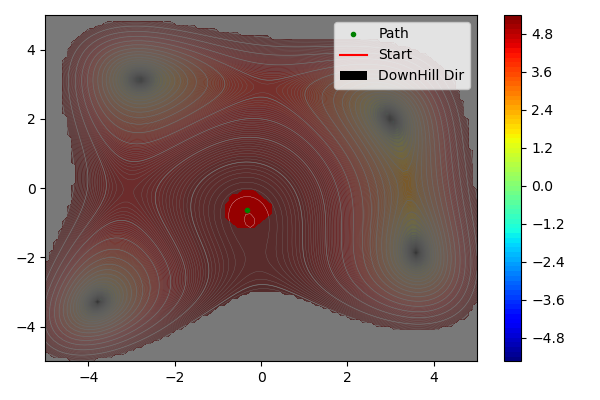

In [13]:
init(px=-0.32, py=-0.62)
alpha = 0.7
mask = maj_mask_all(mask, P)

plt.figure(figsize=(6, 4))
title = plt.title("")
cost_map = plt.contourf(X, Y, np.log(Z), 100, cmap=cm.jet)
plt.colorbar(cost_map)
plt.contour(X, Y, np.log(Z), 500, cmap=cm.gray, zorder=2.0, linewidths=0.2)
plt.contour(X, Y, np.log(Z), 50, cmap=cm.gray, zorder=2.0, linewidths=0.5)
(line,) = plt.plot(P[:, 0], P[:, 1], ".g", label="Path")
(line0,) = plt.plot(P[:1, 0], P[:1, 1], "r", label="Start")


v = plt.quiver(
    P[:, 0],
    P[:, 1],
    V_down_hill_dir[:, 0],
    V_down_hill_dir[:, 1],
    scale=10,
    zorder=2.4,
    width=0.005,
    label="DownHill Dir",
    angles="xy",
)
p = [plt.contourf(X, Y, mask, 2, cmap=cm.gray, zorder=2.3, alpha=alpha)]

plt.legend()
plt.tight_layout()
# get ax object
ax = plt.gca()

counter = 0


@ipw.interact_manual()
def run_step():
    global P, counter, mask, v, V_down_hill_dir

    #optim_grad()
    optim_grad_lin_search()

    mask = maj_mask_all(mask, P)

    for tp in p[0].collections:
        tp.remove()
    v.remove()

    p[0] = plt.contourf(X, Y, mask, 2, cmap=cm.gray, zorder=2.3, alpha=alpha)
    v = plt.quiver(
        P[:, 0],
        P[:, 1],
        V_down_hill_dir[:, 0],
        V_down_hill_dir[:, 1],
        scale=10,
        zorder=2.4,
        width=0.005,
        label="DownHill Dir",
        angles="xy",
    )
    line.set_xdata(P[:, 0])
    line.set_ydata(P[:, 1])
    re = 1.
    # get last point which is not nan
    last_P = P[np.where(~np.isnan(P[:, 0]))][-1]
    # ax.set_xlim([last_P[0] - re, last_P[0] + re])
    # ax.set_ylim([last_P[1] - re, last_P[1] + re])

    # CostOverIt.set_ydata(cost(P.T))